## XS1968784758 geared call

In [1]:
# базовые активы
BAs = ['MNOD LI Equity',
       'CCJ UN Equity',
       'RIO LN Equity',
       'VALE UN Equity']

isin = 'XS1968784758'
notional_curr = 'EUR'
term = 3           # срок жизни ноты в годах
check_months = 3   # раз в сколько месяцев платится купон и проверяется autocall

coupon_value = 0.0275/(12/check_months)
coupon_always = 1
coupon_memory = 0
coupon_lower_barrier = 0.65
coupon_upper_barrier = 10^6

autocall_flag = 1
autocall_barrier = 1.0
autocall_barrier_increase_rate = -0.01

put_strike = 0.65
redemption_amount = 1
guarantee_rule = 1 # worst < put_strike => worst; worst > put_strike => redemption_amount

In [2]:
from pfp_products import *
from pfp_optimization import *
from pfp_stat import *

import numpy as np
import pandas as pd 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime as dat

# set constants & assumbtions
n_scenarios = 50000
simulation_years = 10       # срок моделирования инструментов - 10 лет
points_in_year = 12         # модельных точек в году

n_timepoints = points_in_year*simulation_years
dT = 1/points_in_year

rfr = -0.0025

In [3]:
# сгенерим сценарии
returns = ba_scenarios(BAs, 
                       simulation_years, 
                       points_in_year, 
                       n_scenarios, 
                       print_statistics = False, 
                       rfr = 0.018)

n_points = int(term*points_in_year/check_months)
time_steps = np.arange(check_months - 1, term*points_in_year, check_months)

# autocall triggers
c1 = autocall_barrier + autocall_barrier_increase_rate*np.array(range(0,n_points))
call_trigger = np.reshape(np.repeat(c1, n_scenarios*len(BAs)), (n_points, n_scenarios, len(BAs)))  

positions = []
for a in BAs:
    positions.append(BAs.index(a))

rtrns = (returns[:,:,positions])[time_steps,:,:]

discount_base = np.exp(-rfr*(time_steps + 1)/12)
discount = np.reshape(np.repeat(discount_base, n_scenarios), (n_points, n_scenarios)) 

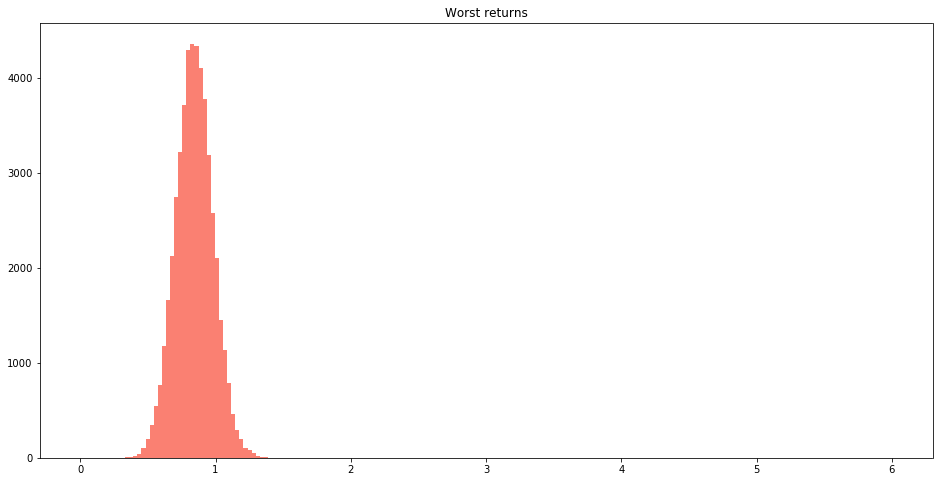

In [4]:
plt.figure(figsize=(16,8))
plt.title('Worst returns')
bins = np.linspace(0,6,200)
plt.hist(returns[12,:,:].min(axis = 1), bins, alpha=1, color = 'salmon')
plt.show()

In [5]:
# автоколл
call_flag = (rtrns > call_trigger).all(axis = 2)
a0 = call_flag
a1 = a0.cumsum(axis = 0)
a2 = (a1 > 0)*1 
a3 = np.roll(a2, 1, axis = 0)
a3[0,:] = 0
call_flag[-1,:] = 0
active_flag = 1 - a3
if autocall_flag == 0: 
    active_flag = np.ones(active_flag)
    
autocalled = active_flag*call_flag

In [6]:
# купоны

if coupon_always == 1:
    coupons = np.ones(active_flag.shape)*coupon_value

else:
    # считаем количество пробитий вверх на контрольные даты
    a1 = ((rtrns > coupon_lower_barrier)*(rtrns < coupon_upper_barrier)).sum(axis = 2) 

    # флаг купона
    a2 = (a1 == len(BAs))*coupon_value
    coupons = a2
    
    if coupon_memory == 1:         
        # купонов с учетом эффекта памяти
        a3 = pd.DataFrame(np.zeros(a2.shape))
        for i in range(0,a3.shape[0]):
            a3.ix[i] = ((i+1) - a3.ix[:i].sum(axis = 0))*pd.DataFrame(a2).ix[i]
        coupons = a3*coupon_value
        
coupons = coupons*active_flag

In [7]:
# на последний день
guarantee_payoff = np.zeros((n_points, n_scenarios))
guarantee_payoff[-1,:] = redemption_amount

if guarantee_rule == 1:
    wrst = rtrns.min(axis = 2)
    worst_last = wrst[-1,:]
    guarantee_payoff[-1,:] = ((worst_last < put_strike)*worst_last + (worst_last >= put_strike))

guarantee_payoff = guarantee_payoff*active_flag

In [8]:
# всего
total_payoff = coupons + autocalled + guarantee_payoff
npv = (total_payoff*discount).sum(axis = 0)
print(npv.mean())

0.941607018384134


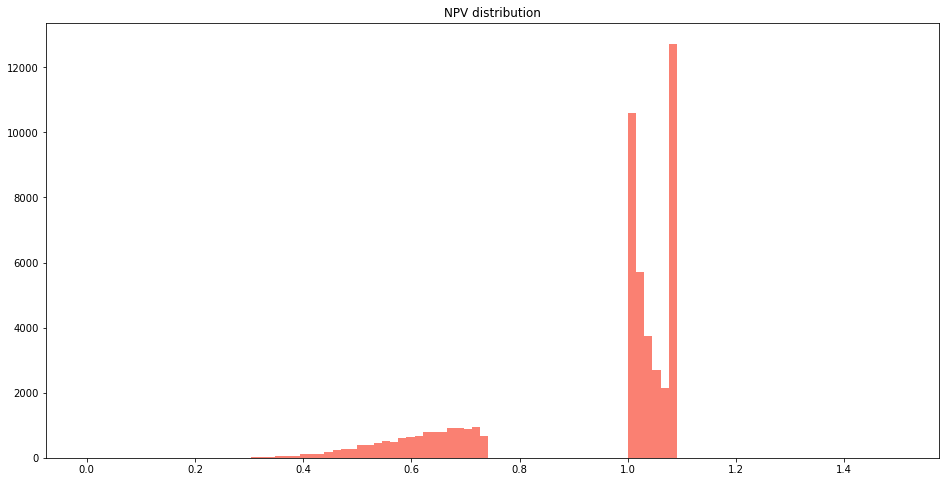

In [9]:
plt.figure(figsize=(16,8))
plt.title('NPV distribution')
bins = np.linspace(0,1.5,100)
plt.hist(npv, bins, alpha=1, color = 'salmon')
plt.show()